# Lab 5 Report

Prepared by Zech Wolf

## 1. Data preparation

I use the personal key indicators of heart disease dataset found on Kaggle. The data has a mix of continuous and categorical features, and contains over 300,000 instances. The target variable is "HeartDisease" which indicates whether or not a patient has experienced heart disease. This will be label encoded as 0 or 1.

There are 17 features in the dataset, both categorical and continuous. The categorical features will be label encoded as integers to support embedding. The continuous features will be processed through a standard scaler.

Dataset source: https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease?resource=download

### 1.1 Preprocessing

In [354]:
import pandas as pd

df = pd.read_csv("datasets/heart_2020_cleaned.csv")

#Quality check
df.isna().any()

HeartDisease        False
BMI                 False
Smoking             False
AlcoholDrinking     False
Stroke              False
PhysicalHealth      False
MentalHealth        False
DiffWalking         False
Sex                 False
AgeCategory         False
Race                False
Diabetic            False
PhysicalActivity    False
GenHealth           False
SleepTime           False
Asthma              False
KidneyDisease       False
SkinCancer          False
dtype: bool

#### Feature summary

| __Feature__ | __Type__ | __Representation__ |
|----|----|----|
| BMI | continuous | float |
| Smoking | categorical | int |
| AlcoholDrinking | categorical | int |
| Stroke | categorical | int |
| PhysicalHealth | continuous | float |
| MentalHealth | continuous | float |
| DiffWalking | categorical | int |
| Sex | categorical | int |
| AgeCategory | ordinal | int |
| Race | categorical | int |
| Diabetic | categorical | int |
| PhysicalActivity | categorical | int |
| GenHealth | ordinal | int |
| SleepTime | continuous | float |
| Asthma | categorical | int |
| KidneyDisease | categorical | int |
| SkinCancer | categorical | int |
| HeartDisease (target) | categorical | int |

#### Undersampling

The dataset is highly imbalanced towards the negative class, so I equalize the number of instances per class by undersampling. Since there are about 27,000 instances of the positive class, the undersampled dataset will still have over 50,000 instances to work with.

In [355]:
df_neg = df[df.HeartDisease == "No"]
df_pos = df[df.HeartDisease == "Yes"]

df = pd.concat([df_neg.sample(n=len(df_pos), random_state=1234), df_pos])

#### Label encoding

There are quite a few categorical and ordinal features given in string format. These need to be replaced with integers in order to create embeddings later on.

In [356]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

cat_columns = ["Smoking", "AlcoholDrinking", "Stroke", "DiffWalking",
                "Sex", "Race", "Diabetic", "PhysicalActivity", "Asthma",
                "KidneyDisease", "SkinCancer", "AgeCategory", "GenHealth"]

df.replace(to_replace=["Poor","Fair","Good","Very good","Excellent"],
            value=["1Poor","2Fair","3Good","4Very good","5Excellent"],
            inplace=True) #alphabetize genhealth so it works with label encoder

le = dict()

for col in cat_columns:
    enc = LabelEncoder()
    colname = f"{col}_lbl"
    df[colname] = enc.fit_transform(df[col])
    le[colname] = enc #store in dict with col name as key

cat_cols_lbl = [f"{col}_lbl" for col in cat_columns]

#Label encode target - doesnt need a new column
df["HeartDisease"] = LabelEncoder().fit_transform(df["HeartDisease"])

### 1.2 Cross product features

Three different categories of features are chosen to create three cross product columns for use in the wide branch of the neural networks.

* Demographic features: AgeCategory, Sex, Race

According the the CDC (https://www.cdc.gov/heartdisease/risk_factors.htm), heart disease risk increases with age. Although the CDC does not emphasize major differences in risk between sex and race categories, it still might be helpful to look at a combination of all three of these factors as general demographic information to observe if there is any similarity between combinations of these categories that might help with memorization in the wide branch.


* Habit features: Smoking, AlcoholDrinking, PhysicalActivity

Referring again to the CDC source above, these three lifestyle choices are important factors in determining risk for heart disease. Creating a cross product of these features may help a network memorize that healthier habits mean heart disease is less likely, while unhealthier habits make it more likely.

* Health condition features: Stroke, DiffWalking, Diabetic, Asthma, KidneyDisease, SkinCancer

These features represent different health conditions that a patient might have. Having more of these conditions could be indicative of weaker health, translating to a higher risk of heart disease. The cross product of this feature provides a very specific label for the combinations of these conditions, which could help the network associate a combination of conditions with heart disease risk.

### 1.3 Evaluation metrics

This dataset is focused on helping to identify risk of heart disease. The target is a binary yes/no variable indicating whether a patient has experienced heart disease. In a potential business case, information about current patients could be used to predict if the patient is at risk of heart disease, and help physicians to recommend treatments and protocols based on the prediction.

In this case, it would be most important to have a high true positive rate, because there is a high cost for false negatives. If a patient is actually at risk but is misidentified as being not at risk, they might not get the proper treatment to mitigate the risk of heart disease. On the other hand, a false positive could mean that a patient is referred to treatment that is not strictly necessary. While this is not a preferable outcome, the cost is much less signficant than the cost of false negatives. Thus I will use recall as the evaluation metric, to optimize for identifying the highest proportion of the real positives while minimizing false negatives.

### 1.4 Train test split

The undersampled dataset is very large, with over 50,000 instances, so an 80/20 train-test split should be sufficient. The classes are balanced because of the undersampling process, so to make sure that the balance is maintained in the split, I use the stratification option in sklearn's function.

In practice, a trained model would be used to predict the risk of heart disease based on a current patient's information. In general, it is best for the testing set to reflect the class distribution that would be seen in a real deployment, which could be achieved by sampling the testing set. However, since the evaluation metric is recall, the class distribution of the testing set should not have a significant effect. Recall is only concerned with the number of actual positives that were identified correctly, so the ratio of actual negatives to actual positives is not very important. Since the full dataset was already undersampled to achieve class balance in the training set, sampling the testing set further would only mean discarding more samples with little benefit. So, in summary, an 80/20 split on the balanced, undersampled dataset is a good and realistic option for cross validation.

In [357]:
from sklearn.model_selection import train_test_split

X = df.drop(columns="HeartDisease")
y = df["HeartDisease"].to_numpy()

df_train, df_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8, test_size=0.2)

#### Feature normalization

Scaling is done separately on training and testing sets

In [358]:
from sklearn.preprocessing import StandardScaler

numeric_cols = ["BMI", "PhysicalHealth", "MentalHealth", "SleepTime"]
scaler = StandardScaler()

for col in numeric_cols:
    df_train[col] = scaler.fit_transform(df_train[col].to_numpy().reshape(-1,1))
    df_test[col] = scaler.fit_transform(df_test[col].to_numpy().reshape(-1,1))

## 2. Modeling

#### Helper functions and preparation

In [359]:
#These functions are adapted from the class examples
def cross_features(col_lists):
    """Adds the crossed column to the df"""

    cross_col_df_names = list()

    for cols in col_lists:
        # encode as ints for the embedding
        enc = LabelEncoder()
        
        # 1. create crossed labels by join operation
        X_crossed_train = df_train[cols].apply(lambda x: '_'.join(x), axis=1)
        X_crossed_test = df_test[cols].apply(lambda x: '_'.join(x), axis=1)
        
        # get a nice name for this new crossed column
        cross_col_name = '_'.join(cols)
        
        # 2. encode as integers, stacking all possibilities
        enc.fit(np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy())))
        
        # 3. Save into dataframe with new name
        df_train[cross_col_name] = enc.transform(X_crossed_train)
        df_test[cross_col_name] = enc.transform(X_crossed_test)
        
        # Save the encoder used here for later:
        le[cross_col_name] = enc
        
        # keep track of the new names of the crossed columns
        cross_col_df_names.append(cross_col_name)

    return cross_col_df_names

In [360]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, Input, concatenate
from tensorflow.keras.models import Model

def get_wide_branch(cross_cols):
    """Build the wide branch of the network based on the given crossed columns"""
    # we need to create separate lists for each branch
    crossed_outputs = []

    # CROSSED DATA INPUT
    input_crossed = Input(shape=(len(cross_cols),), dtype='int64', name='wide_inputs')
    for idx,col in enumerate(cross_col_df_names):
        
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = len(le[col].classes_)
        N_reduced = int(np.sqrt(N))
        
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_crossed, idx, axis=1)
        
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                    output_dim=N_reduced, 
                    input_length=1, name=col+'_embed')(x)
        
        # save these outputs to concatenate later
        crossed_outputs.append(x)

    # now concatenate the outputs and add a fully connected layer
    wide_branch = concatenate(crossed_outputs, name='wide_concat')

    return input_crossed, wide_branch

In [361]:
def get_deep_branch(layers):
    """
    Creates the deep branch of the network
    layers : tuple with the sizes of each layer

    Uses global arrays cat_cols_lbl and numeric_cols for reference
    """
    
    all_deep_branch_outputs = []

    # CATEGORICAL DATA INPUT
    input_cat = Input(shape=(len(cat_cols_lbl),), dtype='int64', name='categorical_input')
    for idx,col in enumerate(cat_cols_lbl):
        N = len(le[col].classes_)
        N_reduced = int(np.sqrt(N))
        
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cat, idx, axis=1)
        
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                    output_dim=N_reduced, 
                    input_length=1, name=col+'_embed')(x)
        
        # save these outputs to concatenate later
        all_deep_branch_outputs.append(x)
        
    # NUMERIC DATA INPUT
    # create dense input branch for numeric
    input_num = Input(shape=(len(numeric_cols),), name='numeric')
    x_dense = Dense(units=20, activation='relu',name='num_1')(input_num)

    all_deep_branch_outputs.append(x_dense)

    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')

    for i,n in enumerate(layers):
        deep_branch = Dense(units=n,activation='relu', name=f'deep{i+1}')(deep_branch)

    return input_cat, input_num, deep_branch

In [362]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

def plot_performance(hist):
    plt.figure(figsize=(14,6))

    #Recall plot
    plt.subplot(1,2,1)
    epochs = range(len(hist.epoch))
    recall = hist.history["recall"]
    val_recall = hist.history["val_recall"]

    sns.lineplot(x=epochs, y=recall, label="Training recall")
    sns.lineplot(x=epochs, y=val_recall, label="Validation recall")

    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.legend()
    plt.title("Recall vs. Epoch")

    #Loss plot
    plt.subplot(1,2,2)
    loss = hist.history["loss"]
    val_loss = hist.history["val_loss"]

    sns.lineplot(x=epochs, y=loss, label="Training loss")
    sns.lineplot(x=epochs, y=val_loss, label="Validation loss")

    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.legend()
    plt.title("Loss vs. Epoch")
    plt.show()


In [363]:
#These inputs wont change for now
X_train_cat = df_train[cat_cols_lbl].to_numpy() 
X_test_cat = df_test[cat_cols_lbl].to_numpy() 

X_train_num =  df_train[numeric_cols].to_numpy()
X_test_num = df_test[numeric_cols].to_numpy()

In [364]:
from sklearn.metrics import recall_score

def model_report(model, X_train_crossed, X_test_crossed):
    hist = model.fit([X_train_crossed, X_train_cat, X_train_num], y_train,
            epochs=50, batch_size=5000, verbose=0,
            validation_data=([X_test_crossed, X_test_cat,X_test_num], y_test))

    y_pred = model.predict([X_test_crossed, X_test_cat, X_test_num]) #crossed feature df will be changing so it needs to be passed in
    y_pred = np.round(y_pred)

    plot_performance(hist)
    print(f"Recall: {recall_score(y_test, y_pred)}")

    return y_pred

In [365]:
#McNemars test for stat comparison
def get_contingency(yhat1, yhat2, y):
    """Generate the contingency matrix """
    contingency = np.zeros((2,2))
    for i in range(len(y)): #slow but it works
        if yhat1[i] == y[i] and yhat2[i] == y[i]: #A
            contingency[0,0] += 1
        elif yhat1[i] == y[i] and yhat2[i] != y[i]: #B
            contingency[0,1] += 1
        elif yhat1[i] != y[i] and yhat2[i] == y[i]: #C
            contingency[1,0] += 1
        elif yhat1[i] != y[i] and yhat2[i] != y[i]: #D
            contingency[1,1] += 1

    return contingency

def mcnemar(yhat1, yhat2, y):
    """Get the chi2 value for McNemar's test"""
    contingency = get_contingency(yhat1, yhat2, y)
    B = contingency[0,1]
    C = contingency[1,0]

    return ((np.abs(B-C) - 1)**2) / (B + C)

### 2.1 Wide and deep networks

Three different wide and deep networks are created and compared. The characteristics of the three networks are:

* Demographic and habits cross columns in the wide branch, one layer deep branch
* Demographic, habits, and health conditions cross columns in the wide branch, one layer deep branch
* Demographic, habits, and health conditions cross columns in the wide branch, three layer deep branch

#### 2.1.1 Model 1 - Demographic and habit crossed columns

In [366]:
#Generate the wide and deep branches
cross_col_df_names = cross_features([ ["Sex", "AgeCategory", "Race"],
                                        ["AlcoholDrinking", "Smoking", "PhysicalActivity"] ])
input_crossed, wide_branch = get_wide_branch(cross_col_df_names)
input_cat, input_num, deep_branch = get_deep_branch((50,))

# get crossed columns
X_train_crossed = df_train[cross_col_df_names].to_numpy()
X_test_crossed = df_test[cross_col_df_names].to_numpy()

# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                        name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                    name='combined')(final_branch)

model = Model(inputs=[input_crossed,input_cat,input_num], 
            outputs=final_branch)

model.compile(optimizer="adam",
              loss=[tf.keras.losses.BinaryCrossentropy()],
              metrics=["Recall"])

343/343 [==============================] - 3s 9ms/step


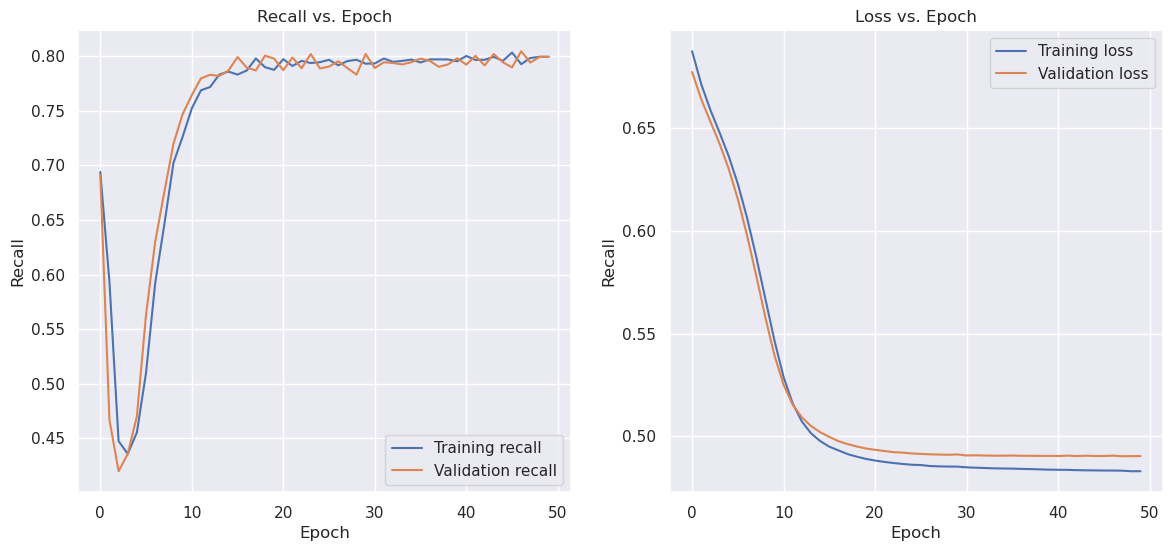

Recall: 0.7992694063926941


In [367]:
y_pred_m1 = model_report(model, X_train_crossed, X_test_crossed)

#### 2.1.2 Model 2 - Demographic, habit, and health condition crossed columns

In [368]:
#Generate the wide branch
cross_col_df_names = cross_features([ ["Sex", "AgeCategory", "Race"],
                                        ["AlcoholDrinking", "Smoking", "PhysicalActivity"],
                                        ["Stroke","DiffWalking","Diabetic","Asthma","KidneyDisease","SkinCancer"] ])
input_crossed, wide_branch = get_wide_branch(cross_col_df_names)
input_cat, input_num, deep_branch = get_deep_branch((50,))

# get crossed columns
X_train_crossed = df_train[cross_col_df_names].to_numpy()
X_test_crossed = df_test[cross_col_df_names].to_numpy()

# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                        name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                    name='combined')(final_branch)

model = Model(inputs=[input_crossed,input_cat,input_num], 
            outputs=final_branch)

model.compile(optimizer="adam",
              loss=[tf.keras.losses.BinaryCrossentropy()],
              metrics=["Recall"])

343/343 [==============================] - 2s 6ms/step


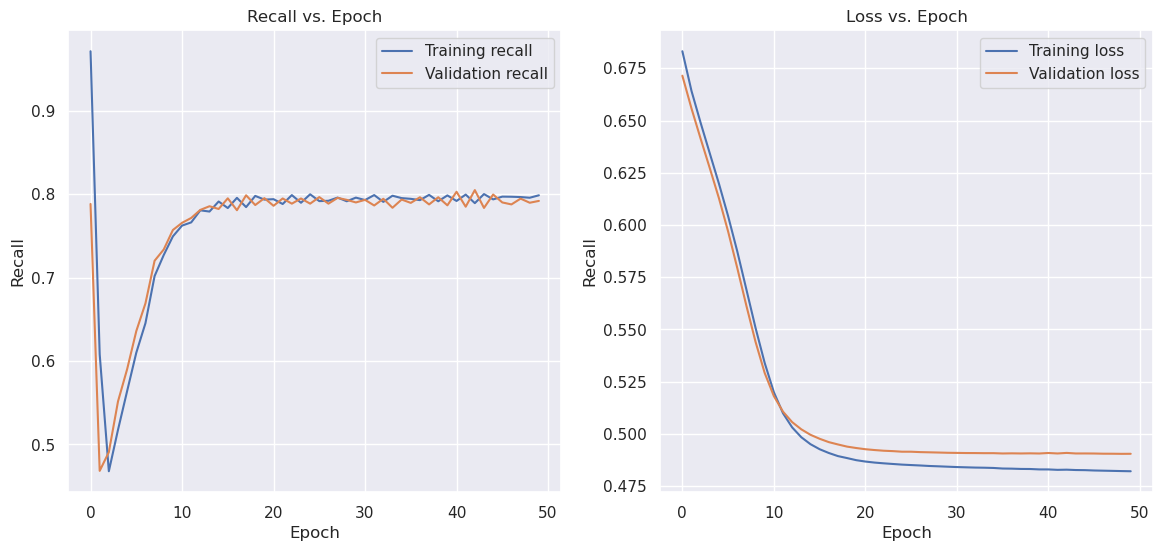

Recall: 0.7921461187214612


In [369]:
y_pred_m2 = model_report(model, X_train_crossed, X_test_crossed)

#### Comparing model 1 and model 2 - McNemar's test

The critical value for a 95% confidence interval is $3.841$ for McNemar's test. If the test result exceeds this value, then there is a statistically significant difference between the two neural networks

In [370]:
p = mcnemar(y_pred_m1, y_pred_m2, y_test)
print("Model 1 vs. Model 2:", p)

Model 1 vs. Model 2: 1.610062893081761


The result is not larger than the critical value, so we cannot say that there is a statistically significant difference between the models, although model 1 performed slightly better in terms of recall on the testing set. The next model will have three layers in the deep branch instead of one. I am arbitrarily choosing model 2's wide branch structure to use in the next model.

#### 2.1.3 Model 3 - Three layers in the deep branch

This is the same as model 2, except there are three layers in the deep branch

In [371]:
#Generate the wide branch
cross_col_df_names = cross_features([ ["Sex", "AgeCategory", "Race"],
                                        ["AlcoholDrinking", "Smoking", "PhysicalActivity"],
                                        ["Stroke","DiffWalking","Diabetic","Asthma","KidneyDisease","SkinCancer"] ])
input_crossed, wide_branch = get_wide_branch(cross_col_df_names)
input_cat, input_num, deep_branch = get_deep_branch((50,25,12,)) #three layers

# get crossed columns
X_train_crossed = df_train[cross_col_df_names].to_numpy()
X_test_crossed = df_test[cross_col_df_names].to_numpy()

# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                        name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                    name='combined')(final_branch)

model = Model(inputs=[input_crossed,input_cat,input_num], 
            outputs=final_branch)

model.compile(optimizer="adam",
              loss=[tf.keras.losses.BinaryCrossentropy()],
              metrics=["Recall"])

343/343 [==============================] - 2s 5ms/step


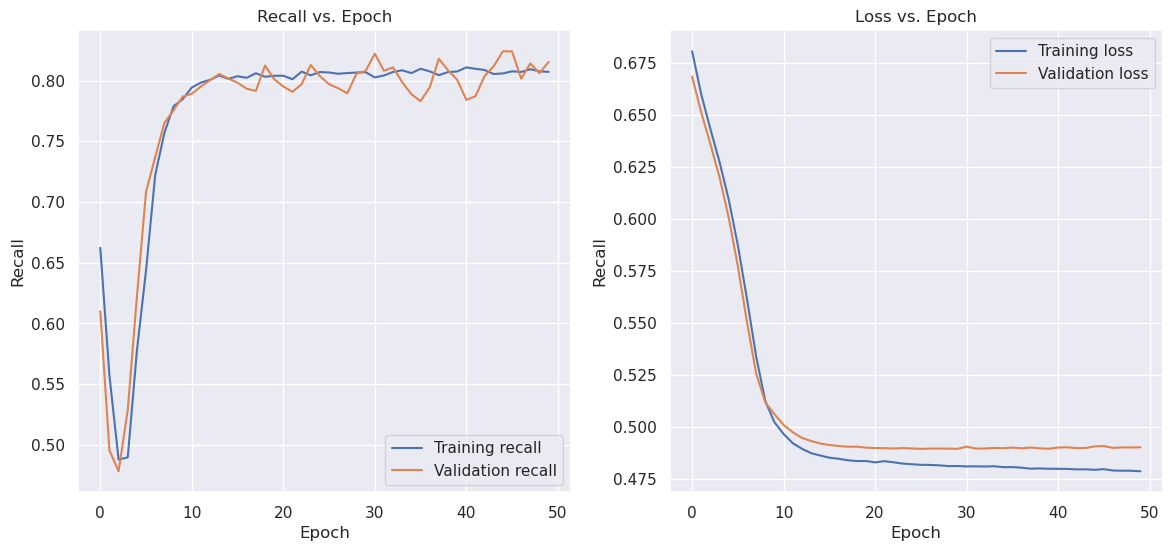

Recall: 0.8155251141552512


In [372]:
y_pred_m3 = model_report(model, X_train_crossed, X_test_crossed)

#### Comparing model 2 and 3 - McNemar's test

Model 3 performs better in terms of recall. McNemar's test is needed to determine if this is a statistically significant difference.

In [373]:
p = mcnemar(y_pred_m2, y_pred_m3, y_test)
print("Model 2 vs. Model 3:", p)

p = mcnemar(y_pred_m1, y_pred_m3, y_test) #compare to m1 as well
print("Model 1 vs. Model 3:", p)

Model 2 vs. Model 3: 2.8255813953488373
Model 1 vs. Model 3: 0.40160642570281124


The result does not exceed the critical value of $3.841$ so there is no statistical difference between model 2 and 3 (or model 1 vs. 3). Between these three models, we cannot determine which one is the best. For the next comparison though, I arbitrarily choose model 3, since it uses the most crossed features, and has the most layers in the deep branch. Hopefully, this choice will best highlight the differences between a wide and deep network, and a network with only a deep branch, in the next section.

### 2.3 Wide and deep vs. deep only

The wide and deep network with 3 layers is compared with a network with only a deep branch.

In [302]:
#Wide and deep model
cross_col_df_names = cross_features([ ["Sex", "AgeCategory", "Race"],
                                        ["AlcoholDrinking", "Smoking", "PhysicalActivity"],
                                        ["Stroke","DiffWalking","Diabetic","Asthma","KidneyDisease","SkinCancer"] ])
input_crossed, wide_branch = get_wide_branch(cross_col_df_names)
input_cat, input_num, deep_branch = get_deep_branch((50,25,12))

# get crossed columns
X_train_crossed = df_train[cross_col_df_names].to_numpy()
X_test_crossed = df_test[cross_col_df_names].to_numpy()

# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                        name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                    name='combined')(final_branch)

model_wd = Model(inputs=[input_crossed,input_cat,input_num], 
            outputs=final_branch)

model_wd.compile(optimizer="adam",
              loss=[tf.keras.losses.BinaryCrossentropy()],
              metrics=["Recall"])

#Deep model
input_cat_d, input_num_d, deep_branch_d = get_deep_branch((50,25,12))
deep_output = Dense(units=1, activation="sigmoid", name="deep_out")(deep_branch_d)
model_d = Model(inputs=[input_cat_d,input_num_d], outputs=deep_output)
model_d.compile(optimizer="adam",
              loss=[tf.keras.losses.BinaryCrossentropy()],
              metrics=["Recall"])

In [303]:
hist_wd = model_wd.fit([X_train_crossed, X_train_cat, X_train_num], y_train,
            epochs=50, batch_size=5000, verbose=0,
            validation_data=([X_test_crossed, X_test_cat,X_test_num], y_test))

hist_d = model_d.fit([X_train_cat, X_train_num], y_train,
            epochs=50, batch_size=5000, verbose=0,
            validation_data=([X_test_cat,X_test_num], y_test))

In [304]:
y_prob_wd = model_wd.predict([X_test_crossed, X_test_cat, X_test_num])
y_prob_d = model_d.predict([X_test_cat, X_test_num])
y_pred_wd = np.round(y_prob_wd)
y_pred_d = np.round(y_prob_d)

343/343 [==============================] - 3s 7ms/step


#### ROC Curve

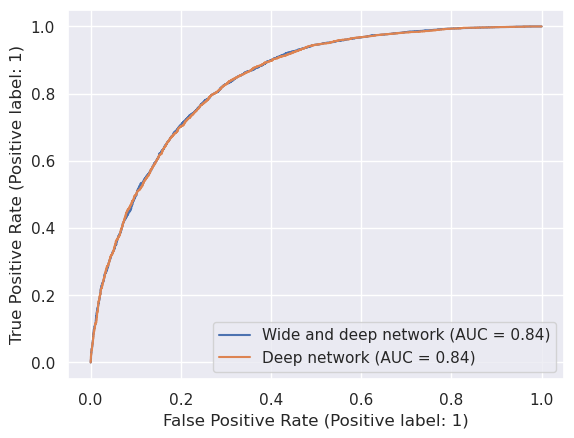

In [305]:
from sklearn.metrics import RocCurveDisplay

fig = RocCurveDisplay.from_predictions(y_test, y_prob_wd, name="Wide and deep network")
RocCurveDisplay.from_predictions(y_test, y_prob_d, ax=fig.ax_, name="Deep network")
plt.show()

Both models have the same AUC. The curves are also very similar in structure, so it is difficult to say if one is preferable based on true positive rate. For a final comparison, McNemar's test should be used, and if there is a statistical difference, the model with the higher recall score on the test set is preferable.

#### McNemar's test

In [306]:
p = mcnemar(y_pred_wd, y_pred_d, y_test)
print("Wide and deep vs. deep only:", p)

Wide and deep vs. deep only: 4.1087378640776695


The result exceeds the critical value, so these models are statistically different. To determine which one is better for the business case, we can look at the confusion matrices and recall scores to see how each model performed, since the AUC was the same between the models.

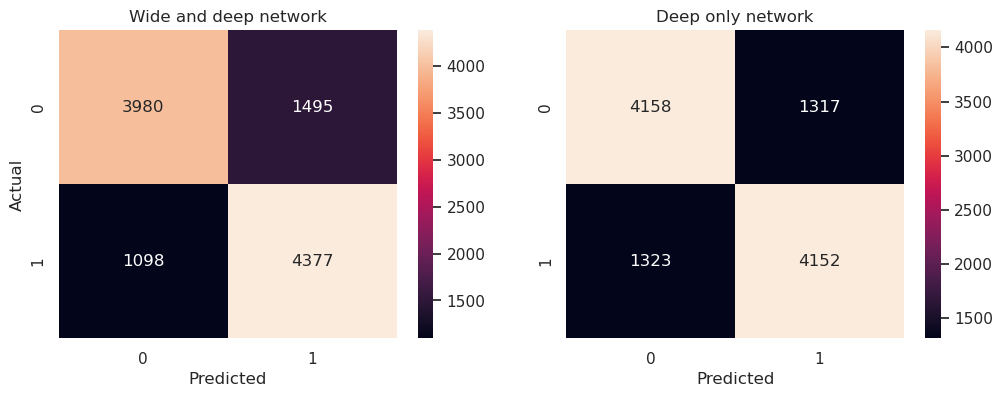

In [309]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test, y_pred_wd), annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Wide and deep network")

plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, y_pred_d), annot=True, fmt="d")
plt.xlabel("Predicted")
plt.title("Deep only network")
plt.show()

In [310]:
print("Wide and deep recall:", recall_score(y_test, y_pred_wd))
print("Deep only recall:", recall_score(y_test, y_pred_d))

Wide and deep recall: 0.7994520547945205
Deep only recall: 0.7583561643835617


The wide and deep network has a higher recall score. The confusion matrices show that this means the wide and deep network is slightly better at identifying true positives, and minimizing false negatives. Although this comes at the cost of a higher false positive rate, for this business case, the true positive rate is more important. Since McNemar's test showed that the models are different, this means that the wide and deep network is in fact the better model in terms of recall score.

## 4. Exceptional Work - Visualizing the embedding space

In [419]:
embed_layers = [layer for layer in model_d.layers if "embed" in layer.name and "concat" not in layer.name]

for layer in embed_layers:
    w = layer.get_weights()[0]
    print(layer.name, w.shape)

Smoking_lbl_embed (2, 1)
AlcoholDrinking_lbl_embed (2, 1)
Stroke_lbl_embed (2, 1)
DiffWalking_lbl_embed (2, 1)
Sex_lbl_embed (2, 1)
Race_lbl_embed (6, 2)
Diabetic_lbl_embed (4, 2)
PhysicalActivity_lbl_embed (2, 1)
Asthma_lbl_embed (2, 1)
KidneyDisease_lbl_embed (2, 1)
SkinCancer_lbl_embed (2, 1)
AgeCategory_lbl_embed (13, 3)
GenHealth_lbl_embed (5, 2)


Many of the categorical features have only two unique values, so the embedding space is one dimensional. Several of the features have a 2D embedding space, and one of the features, AgeCategory, has a 3D embedding space.

The 2 and 3D embeddings are visualized as a scatterplot with all the categories

In [412]:
def plot_weights2d(w, colname):
    sns.scatterplot(x=w[:,0], y=w[:,1])

    #Label the points
    labels = le[colname[0:-6]].classes_ #substring to get rid of _embed from name
    for i in range(len(w)):
        plt.text(x=w[i,0], y=w[i,1], s=labels[i])

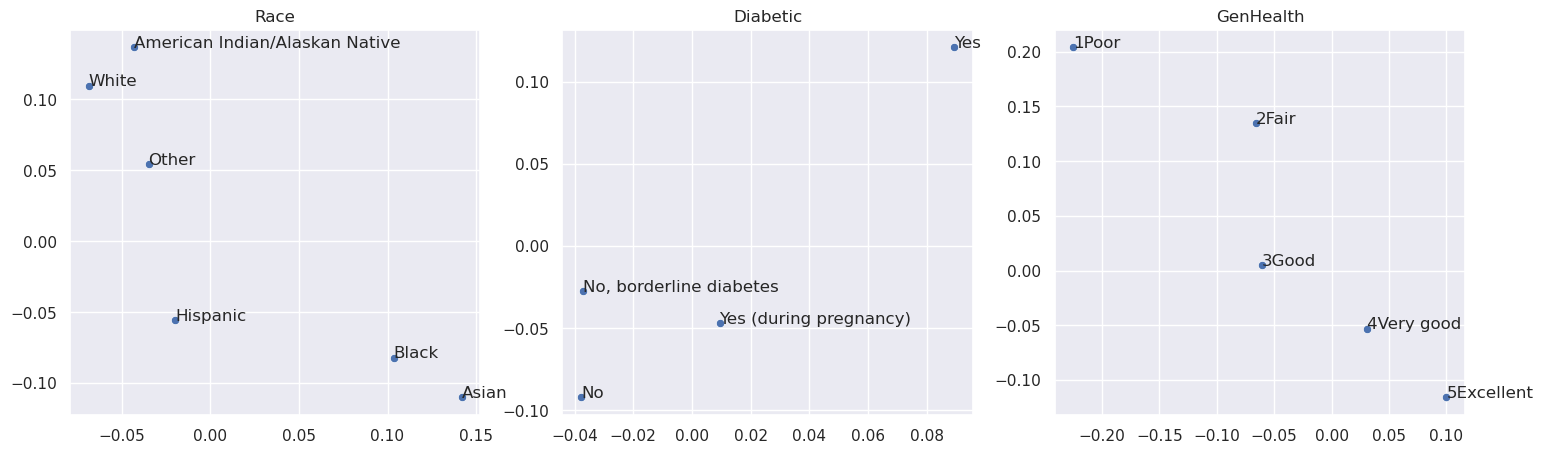

In [422]:
#2D plots
plt.figure(figsize=(18,5))
for i,embed in enumerate(["Race_lbl_embed", "Diabetic_lbl_embed", "GenHealth_lbl_embed"]):
    w = model_d.get_layer(name=embed).get_weights()[0]
    plt.subplot(1,3,i+1)
    plot_weights2d(w, embed)
    plt.title(embed.split("_")[0])

plt.show()

#### Race

There seems to be two main clusters: (white, American Indian/Alaskan native, other) versus (Hispanic, black, and Asian). This dataset is processed from CDC data, so these are records of American patients. Hispanic, black, and Asian are all larger minority groups in the US, which could explain why they are clustered together in the embedding space. This is consistent with the CDC's heart disease risk summary (https://www.cdc.gov/heartdisease/risk_factors.htm), which says there are differences between ethnic groups in heart disease risk based on differing vulnerability to various conditions that increase risk of heart disease. The CDC has also documented that research is supporting the idea that racism can create disparate health outcomes (https://www.cdc.gov/minorityhealth/racism-disparities/index.html). This could help explain the difference in the clustering between the majority ethnic group, white, with the minority groups. It is interesting though that the minority groups of native and "other" are closer to the white group than the other minority groups. Race and racism are very complex topics though, so this is by no means a full accounting for this clustering.

#### Diabetes

The "Yes" category is very different from the "No" categories (or yes during pregnancy). Diabetes is one of the main risk factors for heart disease according to the CDC source, so it makes sense that the model learned to treat diabetic patients very differently from non-diabetic patients.

#### General health

Poor is very different from the other categories. The "good" and above categories seem to form a cluster of their own, while the "fair" category is in between the poor and good, but closer to good than poor. It would make sense that the model is learning that patients with good general health should be treated similarly, while patients with poorer health should be treated differently. This coincides with the generalization that patients with poorer health are more prone to heart disease than those with better health.

#### Age category

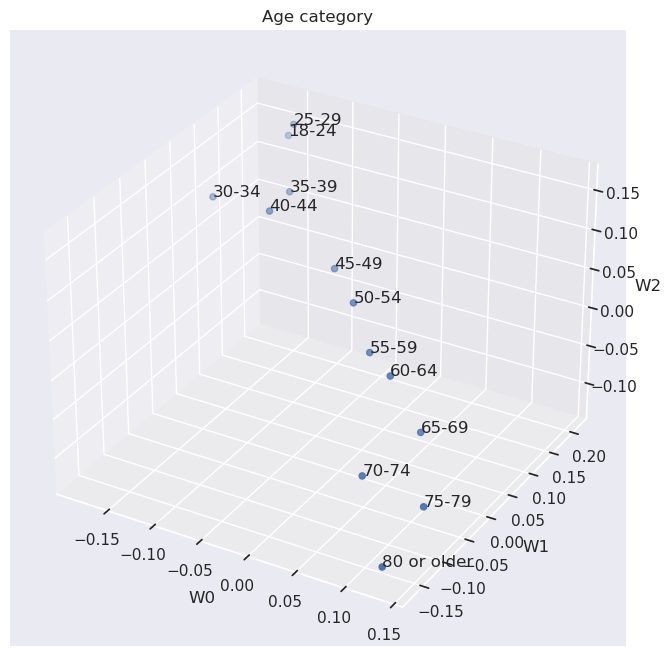

In [440]:
#3D plot for age

w = model_d.get_layer("AgeCategory_lbl_embed").get_weights()[0]

wdf = pd.DataFrame({
    "w0": w[:,0],
    "w1": w[:,1],
    "w2": w[:,2],
    "lbl": le["AgeCategory_lbl"].classes_
})

#This code is adapted from a matplotlib example
#https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')

ax.scatter(w[:,0], w[:,1], w[:,2])
ax.set_xlabel('W0')
ax.set_ylabel('W1')
ax.set_zlabel('W2')

for i,lbl in enumerate(le["AgeCategory_lbl"].classes_):
    ax.text(w[i,0], w[i,1], w[i,2], s=lbl)

plt.title("Age category")
plt.show()

There seems to be three coherent clusters: 18-44, 45-64, 65-80+. This could represent the categories of young, middle age, and elderly. Interestingly, the "young" cluster looks more coherent than the others. It looks like the model is learning to treat ages 18-44 very similarly, and differently from the other age categories. Referring back to the CDC source on heart disease risks, the chances of having a heart disease incident increase with age. This might explain why the younger groups are clustered together in the embedding space, separately from the middle age and elderly groups.